In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [ ]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("data/kg_train.csv",encoding='latin-1')

test_data = pd.read_csv("data/kg_test.csv",encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)
test_data.fillna("",inplace=True)

print(data.head())

(1000, 2)
                                                text  label
0  DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...      1
1                                           Will do.      0
2  Nora--Cheryl has emailed dozens of memos about...      0
3  Dear Sir=2FMadam=2C I know that this proposal ...      1
4                                                fyi      0
                                                text
0  usiness is for the fact that the deceased man ...
1  They are happy to adjust to the afternoon. I a...
2  Lael Brainard was confirmed 78-19 this afterno...
3  H <hrod17@clintonemail.com>Friday March 26 201...
4  n;"> Dear Good Friend,<br><br><br>I am happy t...


### Let's divide the training and test set into two partitions

In [ ]:
# Your code
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size = 0.2, random_state = 42)



29     ----------- REGARDS, MR NELSON SMITH.KINDLY RE...
535    I have not been able to reach oscar this am. W...
695    ; Huma Abedin B6I'm checking with Pat on the 5...
557    I can have it announced here on Monday - can't...
836        BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...
Name: text, dtype: object
Index([ 29, 535, 695, 557, 836, 596, 165, 918, 495, 824,
       ...
       121, 614,  20, 700,  71, 106, 270, 860, 435, 102],
      dtype='int64', length=800)


## Data Preprocessing

In [8]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [ ]:
# Your code
# Remove inline JavaScript/CSS
def remove_inline_js_css(text):
    text = text.replace("<script>", "").replace("</script>", "")
    text = text.replace("<style>", "").replace("</style>", "")
    return text
# Remove HTML comments
def remove_html_comments(text):
    return text.replace("<!--", "").replace("-->", "")
# Remove HTML tags and remaining tags
def remove_html_tags(text):
    return text.replace("<", "").replace(">", "")

X_train = X_train.apply(remove_inline_js_css)
X_train = X_train.apply(remove_html_comments)
X_train = X_train.apply(remove_html_tags)

X_test = X_test.apply(remove_inline_js_css)
X_test = X_test.apply(remove_html_comments)
X_test = X_test.apply(remove_html_tags)


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [16]:
# Your code
# Remove special characters, numbers, all single characters, single characters from the start, prefixed 'b'. Substitute multiple spaces with a single space. Convert to lowercase.
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = ' '.join([word for word in text.split() if not word.isdigit()])
    return ' '.join(text.split())

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)


## Now let's work on removing stopwords
Remove the stopwords.

In [17]:
# Your code
# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    return ' '.join([word for word in text.split() if word not in stop_words])

X_train = X_train.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)

## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [20]:
# Your code
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def text_preprocessing_lemmatization(text):
    # Step 1: Tokenize the text
    tokens = word_tokenize(text)
    # Step 2: Remove punctuation
    tokenized_tokens = [word for word in tokens if word.isalpha()]
    # Step 3: Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokenized_tokens]
    # Step 4: Return the lemmatized tokens
    return lemmatized_tokens

X_train = X_train.apply(text_preprocessing_lemmatization)
X_test = X_test.apply(text_preprocessing_lemmatization)

## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [29]:
# Your code
# Create Bag of Words (BoW) model
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train.astype(str))
X_test_bow = vectorizer.transform(X_test.astype(str))

# Display the shape of the BOW matrices
print("Shape of X_train_bow:", X_train_bow.shape)
print("Shape of X_test_bow:", X_test_bow.shape)
# Displya the 10 most frequent words in the training and test sets
def display_most_frequent_words(X, vectorizer, n=10):
    feature_names = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    data = [(feature_names[i], sums[0, i]) for i in range(sums.shape[1])]
    sorted_data = sorted(data, key=lambda x: x[1], reverse=True)[:n]
    for word, freq in sorted_data:
        print(f"{word}: {freq}")
print("Most frequent words in training set:")
display_most_frequent_words(X_train_bow, vectorizer, n=10)


Shape of X_train_bow: (800, 23374)
Shape of X_test_bow: (200, 23374)
Most frequent words in training set:
the: 7327
to: 5588
of: 4791
and: 4076
in: 3228
you: 2968
this: 2385
for: 2037
your: 1834
my: 1831


In [22]:
data_train = X_train
data_val = X_test


## Extra features

In [28]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€","$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data_train['money_mark'] = data_train.str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train.str.contains(suspicious_words)*1
data_train['text_len'] = data_train.apply(lambda x: len(x)) 

data_val['money_mark'] = data_val.str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val.str.contains(suspicious_words)*1
data_val['text_len'] = data_val.apply(lambda x: len(x)) 

data_train.head()

29     [regard, mr, nelson, smithkindly, reply, priva...
535    [able, reach, oscar, supposed, send, pdb, rece...
695    [huma, abedin, checking, pat, work, jack, jake...
557                     [announced, monday, cant, today]
836    [bank, africaagence, san, bp, san, pedro, divo...
Name: text, dtype: object

## How would work the Bag of Words with Count Vectorizer concept?

In [30]:
# Your code
# Create Count Vectorizer with Bag of Words (BoW) model
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

X_train_count = count_vectorizer.fit_transform(X_train.astype(str))
X_test_count = count_vectorizer.transform(X_test.astype(str))

# Display the shape of the Count Vectorizer matrices
print("Shape of X_train_count:", X_train_count.shape)
print("Shape of X_test_count:", X_test_count.shape)
# Display the 10 most frequent words in the training and test sets
def display_most_frequent_words_count(X, vectorizer, n=10):
    feature_names = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    data = [(feature_names[i], sums[0, i]) for i in range(sums.shape[1])]
    sorted_data = sorted(data, key=lambda x: x[1], reverse=True)[:n]
    for word, freq in sorted_data:
        print(f"{word}: {freq}")
print("Most frequent words in training set (Count Vectorizer):")
display_most_frequent_words_count(X_train_count, count_vectorizer, n=10)




Shape of X_train_count: (800, 23374)
Shape of X_test_count: (200, 23374)
Most frequent words in training set (Count Vectorizer):
the: 7327
to: 5588
of: 4791
and: 4076
in: 3228
you: 2968
this: 2385
for: 2037
your: 1834
my: 1831


## TD-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [32]:
# Your code
from sklearn.feature_extraction.text import TfidfVectorizer
# Create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.astype(str))
X_test_tfidf = tfidf_vectorizer.transform(X_test.astype(str))
# Display the shape of the TF-IDF matrices
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)


Shape of X_train_tfidf: (800, 23374)
Shape of X_test_tfidf: (200, 23374)


## And the Train a Classifier?

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       125
           1       0.99      0.99      0.99        75

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



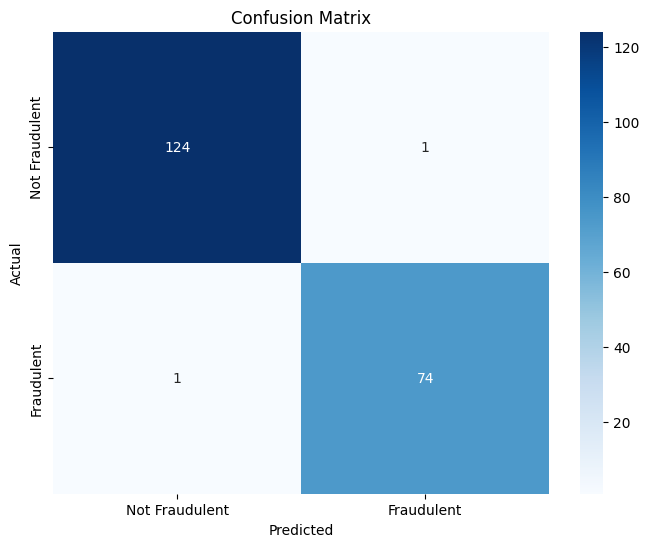

In [ ]:
# Your code
from sklearn.linear_model import LogisticRegressionCV
# Train a Logistic Regression model with cross-validation
log_reg = LogisticRegressionCV(cv=5, max_iter=1000, random_state=42)
log_reg.fit(X_train_tfidf, y_train)
# Evaluate the model on the test set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = log_reg.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraudulent', 'Fraudulent'], yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [38]:
# Preprocess the test data
test_data = test_data.apply(remove_inline_js_css)
test_data = test_data.apply(remove_html_comments)
test_data = test_data.apply(remove_html_tags)

# Clean the test data with modified clean_text function
def clean_text_mod(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = ' '.join([word for word in text.split() if not word.isdigit()])
    return ' '.join(text.split())

test_data = test_data.apply(clean_text_mod)

# Remove stopwords from the test data
test_data = test_data.apply(remove_stopwords)
# Apply lemmatization to the test data
test_data = test_data.apply(text_preprocessing_lemmatization)
# Transform the test data using the trained TF-IDF vectorizer
X_test_final = tfidf_vectorizer.transform(test_data.astype(str))
# Predict using the trained model
test_predictions = log_reg.predict(X_test_final)
# Create a DataFrame for the predictions
submission_df = pd.DataFrame({'id': test_data.index, 'label': test_predictions})


### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to find the **best feature representation**.

You can work with teams of two persons (recommended).

In [ ]:
# Your code